In [202]:
# !apt-get install build-essential python3-dev
# !apt-get install cmake
# !pip install XFoil
# !pip install torch torchvision
! pip install bezier

In [203]:
# code for generating airfoil designs using online airfoil datasets
# code is inspired by:
# The Department of Energy [https://catalog.data.gov/dataset/airfoil-computational-fluid-dynamics-2k-shapes-25-aoas-3-re-numbers]



# specify which platform we are running on 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import os
# import sys
# import math
import time
import copy
import tqdm
# import sklearn
import bezier
import pickle
import platform
import subprocess



# for the GAN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


# importing xfoil itself
# from xfoil import XFoil
# from xfoil.model import Airfoil



# state variables
MAC_PLATFORM = 1
LINUX_PLATFORM = 2
UNKNOWN_PLATFORM = 3
PLATFORM = UNKNOWN_PLATFORM

In [204]:
# get the platform
os_type = platform.system()
if os_type == "Darwin":
	PLATFORM = MAC_PLATFORM
elif os_type == "Linux":
	PLATFORM = LINUX_PLATFORM
else:
	PLATFORM = UNKNOWN_PLATFORM

# should we be verbose
VERBOSE = True

# getting the file that we are currently working in 
# CURR_FILE_DIR = os.path.dirname(os.path.realpath(__file__))
CURR_FILE_DIR = "."

# define the directory that we are working in for the example files
EXAMPLE_DIR = "Example Data"

# the path to the data with the polar data
POLAR_FILE_NAME = "polar.txt"

# setting the path of the airfoil
full_data_path = os.path.join(CURR_FILE_DIR, "airfoil_2k_data.h5")

# path to the example data
example_data_path = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, "b737a.dat")

# defining the data files that we are gonna use
output_file = "polar.dat"
example_data_output = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, output_file)
dump_file = "dump.dat"
example_data_dump = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, dump_file)


# the number of data points that describe each of the point clouds
NUM_POINTS_POINT_CLOUD = 100

# number of random points that we pass to the generator network
RANDOM_INPUT_NUM = 512

# the upper and lower limits for the coefficients (abs val)
COEFF_UPPER = 2

# the amount of data that we are going to use for training
TRAINING_RATIO = 0.9


# the number of epochs to skip between discriminator evaluations
SKIP_EVAL_EPOCHS = 100
BATCH_SIZE = 256

WINDOW_VAL = 7
BEZIER_VAL = 49
 
# whether we should train the model this iteration or not
TRAIN_MODEL = False

# what kind of smoothing we should use
NORMAL_SMOOTH = False
BEZIER_SMOOTH = True


# get the device that we can train on
device = torch.device("cpu")

# make the device cuda if it is available
if torch.cuda.is_available():
	device = torch.device("cuda")


# define the xfoil command depending on the platform
## CHANGE THIS IF NEEDED
if PLATFORM == MAC_PLATFORM:
	home_directory = os.path.expanduser("~")
	XFOIL_COMMAND = f"{home_directory}/Desktop/Xfoil-for-Mac/bin/xfoil"

	# change the device to leverage mps
	# this code taken directly from pytorch docs (https://pytorch.org/docs/stable/notes/mps.html)
	if not torch.backends.mps.is_available():
		if not torch.backends.mps.is_built():
			print("MPS not available because the current PyTorch install was not "
				"built with MPS enabled.")
		else:
			print("MPS not available because the current MacOS version is not 12.3+ "
				"and/or you do not have an MPS-enabled device on this machine.")

	else:
		device = torch.device("mps")

elif PLATFORM == LINUX_PLATFORM:
	XFOIL_COMMAND = "xfoil"

else:
	raise NotImplementedError("Running program on unsupported platform.")


### XFOIL Params
# the reynolds number is used to determine the turbulence of the flow that we are computing
# the metrics of the wing for
# anything > 3500 is turbulent and > 4000 is fully turbulent
reynolds_number = 1e6
# reynolds_number = 0

# the mach number (compression) that we should be computing for here
mach_number = 0.3

# this is the angle of attack that we are going to compute the metrics for 
# the starting angle of attack
s_aot = 2.0

# the ending angle of attack
t_aot = 6.0

# increments for the angle of attack
aot_increments = 1.0



print(f"PLATFORM: {PLATFORM}")
print(f"DEVICE: {device}")


PLATFORM: 1
DEVICE: mps


In [205]:
# getting the points from a file path
# this takes the path to a file that has airfoil points in it as the input to the function
def get_points_from_dat_file(file_path):

	with open(file_path, 'r') as file:
		lines = file.readlines()

	# filter out non-numeric lines and strip whitespace
	points = []
	for line in lines:

		# segment the line
		parts = line.strip().split()

		# split the line and iterate through the parts
		if len(parts) == 2:
			try:
				points.append((float(parts[0]), float(parts[1])))
			except ValueError:
				print(f"Skipping invalid line: {line}")
				pass

	return points


# pull data tensor and information
# from a single folder that has all of the data inside of it
def get_folder_data(folder_path = None, file_name = None):

    # pull the data tensor
    points = get_points_from_dat_file(os.path.join(folder_path, file_name + "_reformatted.dat"))

    # get the tensor
    points = np.array(points)

    # get the other parameters that we want
    resulting_data = pd.read_csv(os.path.join(folder_path, POLAR_FILE_NAME), delim_whitespace=True, skiprows=10)
    resulting_data = resulting_data.drop(0)

    # print(resulting_data)

    # pulling individual values
    alpha = float(resulting_data["alpha"].loc[1].replace("*", ''))   
    CL = float(resulting_data['CL'].loc[1].replace("*", ''))            
    CD = float(resulting_data['CD'].loc[1].replace("*", ''))           
    CDp = float(resulting_data['CDp'].loc[1].replace("*", ''))            
    CM = float(resulting_data['CM'].loc[1].replace("*", ''))     

    # print(f"alpha: {alpha}")
    # print(f"CL: {CL}")
    # print(f"CD: {CD}")
    # print(f"CDp: {CDp}")
    # print(f"CM: {CM}")

    # create labels tensor
    labels = np.array([CL, CDp, CM])

    # if any of the values are out of range then kill this example
    if any(np.abs(labels) > COEFF_UPPER):
        # print(labels)
        raise ValueError("Coefficient Bounds Violated")
	
    if(np.abs(np.array(points)) > 1).any():
        print("POINTS")

    # returning the generated values
    return (points, labels)


# define a function to create the tensors that we need
def pull_airfoil_data(wd=EXAMPLE_DIR):

    # the lists we will return
    ret_data_tensor = []
    ret_labels_tensor = []

    # iterate through all of the potential airfoils
    for airfoil_dat in os.listdir(wd):

        # print the airfoil type
        data_path = os.path.join(EXAMPLE_DIR, airfoil_dat)

        try:
            # pull the data
            t_data, t_labels = get_folder_data(folder_path=data_path, file_name=airfoil_dat)

        except Exception as e:
            if VERBOSE:
                print(f"{data_path} : {e}")
                
            continue

        # add the data to the list
        ret_data_tensor.append(t_data)
        ret_labels_tensor.append(t_labels)

    # print(ret_data_tensor)
    # print(ret_labels_tensor)

    # getting the shapes of the data
    # if VERBOSE

    # convert it to a numpy array
    ret_data_tensor = np.array(ret_data_tensor)
    ret_labels_tensor = np.array(ret_labels_tensor)

    print(f"\n\nret_data_tensor_shapes shapes: {ret_data_tensor.shape}")
    print(f"ret_labels_tensor_shapes shapes: {ret_labels_tensor.shape}")

    # change the final versions to tensors
    ret_data_tensor = torch.Tensor(ret_data_tensor)
    ret_labels_tensor = torch.Tensor(ret_labels_tensor)

    return ret_data_tensor, ret_labels_tensor




# the data sets are going to be formed of:
# 100-dimensional vector representing the input airfoil

# 3-dimensional vector representing the label coefficient, drag-pressure coefficient, and moment coefficient
airfoil_data, label_values = pull_airfoil_data(wd=EXAMPLE_DIR)

Example Data/hq17 : could not convert string to float: '0.000003096.28417'
Example Data/hs1404 : Coefficient Bounds Violated
Example Data/hs1606 : Coefficient Bounds Violated
Example Data/hs1708 : could not convert string to float: '0.000006371.02669'
Example Data/hs1712 : Coefficient Bounds Violated
Example Data/l1003 : Coefficient Bounds Violated
Example Data/a18 : Coefficient Bounds Violated


Example Data/ah63k127 : Coefficient Bounds Violated
Example Data/ah83150q : Coefficient Bounds Violated
Example Data/ah93k132 : Coefficient Bounds Violated
Example Data/b707d : Coefficient Bounds Violated
Example Data/b737a : Coefficient Bounds Violated
Example Data/b737b : could not convert string to float: '0.000001740.48963'
Example Data/bacj : Coefficient Bounds Violated
Example Data/be50 : Coefficient Bounds Violated
Example Data/coanda1 : Coefficient Bounds Violated
Example Data/coanda2 : Coefficient Bounds Violated
Example Data/coanda3 : Coefficient Bounds Violated
Example Data/daytonwright6 : Coefficient Bounds Violated
Example Data/dga1138 : Coefficient Bounds Violated
Example Data/doa5 : Coefficient Bounds Violated
Example Data/dsma523a : Coefficient Bounds Violated
Example Data/e1233 : could not convert string to float: '0.000002620.32015'
Example Data/e266 : Coefficient Bounds Violated
Example Data/e325 : could not convert string to float: '0.000007198.97735'
Example Data/e

In [206]:

# get the shapes to store them
airfoil_data_shape = airfoil_data.shape
label_values_shape = label_values.shape

# change the shape of the airfoil data
airfoil_data_copy = copy.copy(airfoil_data)
airfoil_data = airfoil_data_copy.view(-1, NUM_POINTS_POINT_CLOUD * 2)

print(f"RANDOM_INPUT_NUM: {RANDOM_INPUT_NUM}")

# creating the datasets
total_dataset = TensorDataset(torch.tensor(airfoil_data, dtype=torch.float32), torch.tensor(label_values, dtype=torch.float32))

train_dataset, test_dataset = random_split(total_dataset, [TRAINING_RATIO, 1 - TRAINING_RATIO])

# the train and the test for the data loader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"train_dataloader: {len(train_dataloader) * len(next(iter(train_dataloader))[0])}")
print(f"test_dataloader: {len(test_dataloader) * len(next(iter(test_dataloader))[0])}")

print()

print(f"dataloader: {next(iter(train_dataloader))[0].shape}")
print(f"dataloader: {next(iter(train_dataloader))[1].shape}")
print(f"dataloader: {next(iter(test_dataloader))[0].shape}")
print(f"dataloader: {next(iter(test_dataloader))[1].shape}")

RANDOM_INPUT_NUM: 512
train_dataloader: 288
test_dataloader: 28

dataloader: torch.Size([32, 200])
dataloader: torch.Size([32, 3])
dataloader: torch.Size([28, 200])
dataloader: torch.Size([28, 3])


/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_25327/1680941826.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_dataset = TensorDataset(torch.tensor(airfoil_data, dtype=torch.float32), torch.tensor(label_values, dtype=torch.float32))


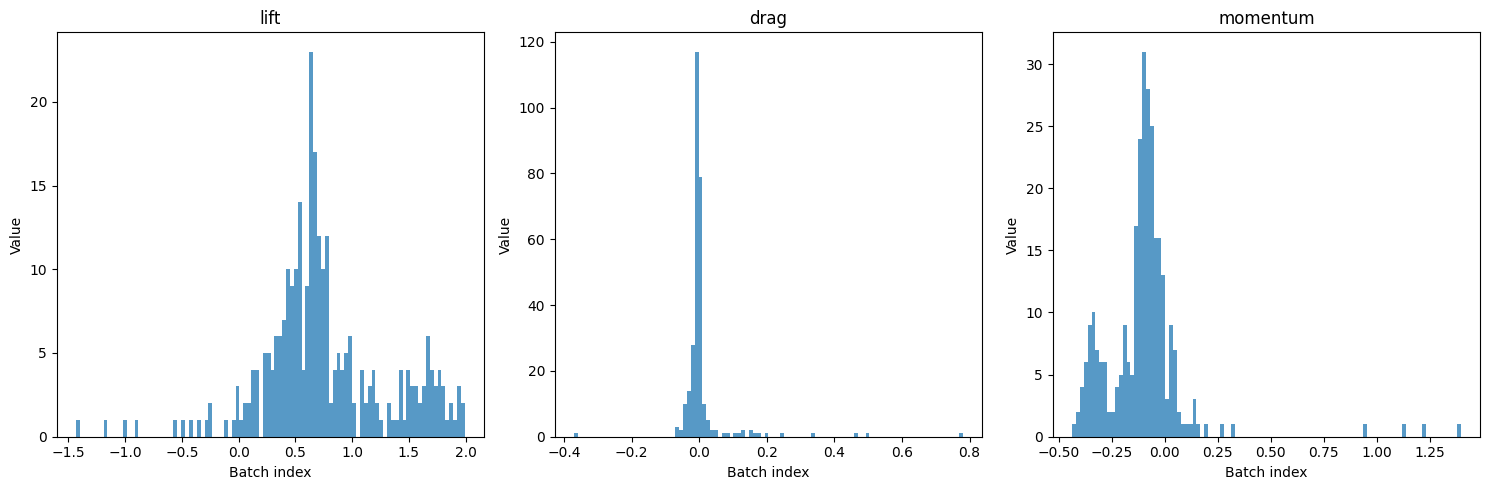

In [207]:
# plot the labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

titles = ['lift', 'drag', 'momentum']

# Plotting each element across the batch
for i in range(3):
    axes[i].hist(label_values[:, i], bins = 100, alpha=0.75, )  # Plot element i across all batches
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Batch index')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [208]:
# now go ahead and define the gan that we are going to be training
class Generator(nn.Module):
    
    def __init__(self, dropout_p=0.2):
        
        super(Generator, self).__init__()
        
        # define the sequential neural network
        self.fc = nn.Sequential(
            nn.Linear(RANDOM_INPUT_NUM + 3, 256),
            # nn.BatchNorm1d(256),
            # nn.LeakyReLU(True),


            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Linear(256, NUM_POINTS_POINT_CLOUD * 2),
            # nn.Tanh()
            # nn.LeakyReLU(0.2),
            # nn.Dropout(dropout_p),
            # nn.Linear(101, 256),  
        )

    # define the forward pass of the sequential neural network
    def forward(self, noise, c_label):

        if c_label.dim() == 1:
            c_label = c_label.unsqueeze(1)

        # concatenate the tensor of variables we want the airfoil to have and the noise
        input_tensor = torch.cat((noise, c_label), dim=1)
        return self.fc(input_tensor.to(device))


# this is the discriminator that is used to assess whether the 
# generator design has the correct lift value
class Discriminator(nn.Module):
    def __init__(self):

        super(Discriminator, self).__init__()

        # defining the sequential discriminator
        self.fc = nn.Sequential(
            nn.Linear(NUM_POINTS_POINT_CLOUD * 2, 64),  # 100 coordinates with 3 computed or real labels and 3 input values
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            # nn.Linear(256, 1),
            nn.Sigmoid()
        )

    # defining the forward pass for the discriminator
    def forward(self, points):

        # putting the tensor of targets together
        # input_tensor = torch.cat((points, labels, target), dim=1)
        return self.fc(points.to(device))
    

# function for initializing the weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)




# create the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# initialize the weights 
generator.apply(weights_init)
discriminator.apply(weights_init)

# create optimizers for the generator and discriminator
# optimizer_G = optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000001)











# this is the validator that is going to decide what the likely value for a certain coefficient is
class Coeff_Validator(nn.Module):
    def __init__(self):

        super(Coeff_Validator, self).__init__()

        # defining the sequential discriminator
        self.fc = nn.Sequential(
            nn.Linear(NUM_POINTS_POINT_CLOUD * 2, 64),  # 100 coordinates
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            # nn.Linear(256, 1),
            # nn.Sigmoid()
        )

    # defining the forward pass for the discriminator
    def forward(self, points):

        # putting the tensor of targets together
        return self.fc(points.to(device))



# this is a function that initializes and creates the validator objects that we are going to use
# in order to train the GAN. These weights will not change
def initialize_validators():

    # initialize the number of discriminators that we need for the number of labels that we pull
    validator_dict = {
        'lift': Coeff_Validator().to(device),
        'drag': Coeff_Validator().to(device),
        'momentum': Coeff_Validator().to(device)
    }

    optimizer_dict = {
        'lift': None,
        'drag': None,
        'momentum': None
    }

    for disc_name, disc_object in validator_dict.items():
        
        # initialize a discriminator
        validator_dict[disc_name] = validator_dict[disc_name].apply(weights_init)

        # create the optimizer
        optimizer_dict[disc_name] = optim.Adam(validator_dict[disc_name].parameters(), lr=0.0002, betas=(0.5, 0.999))

    return validator_dict, optimizer_dict




# function to create noise
def generate_noise(size):
    return torch.randn(size, RANDOM_INPUT_NUM).to(device)



# define a class for early stopping
class EarlyStopping:
    
    # initialize the class
    def __init__(self, patience=7, min_delta=0, saving_path="best_model.ckpt"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.b_loss = None
        self.early_stop = False
        self.saving_path = saving_path

    def __call__(self, v_loss, e_model):
        
        # update the early stopping params
        if self.b_loss is None:
            self.b_loss = v_loss
            self.save_checkpoint(v_loss, e_model)

        # check if we should update
        elif v_loss > self.b_loss - self.min_delta:
            self.counter += 1
            
            # if VERBOSE:
            #     print(f'EarlyStopping counter: {self.counter} out of {self.patience} | {v_loss:.4f}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        
        else:
            self.save_checkpoint(v_loss, e_model)
            self.b_loss = v_loss
            self.counter = 0

    # save the model checkpoint
    def save_checkpoint(self, val_loss, model):
        print(f'Lower Validation Loss ({self.b_loss:.6f} --> {val_loss:.6f})')
        torch.save(model.state_dict(), self.saving_path)

    def load_checkpoint(self, model):
        model.load_state_dict(torch.load(self.saving_path))


# define a function that is going to pre-train the validators
# these are going to be used in place of CFD for inside of the training function for the sake of time 
# they will output the coefficient value that they think is right for some input point cloud
def train_validators(epochs, data_loader, test_loader, validator_dict, optimizer_dict):

    # create the loss function
    loss_function = nn.MSELoss()
    
    # keeping track of the total loss
    loss_dict = {}

    # iterate through the discriminators to update the parameters
    for disc_name, disc_object in validator_dict.items():

        # initalize an early stopping value for this validator
        early_stop = EarlyStopping(patience=10, min_delta=0.01)

        print(f"\n\nTraining {disc_name}")

        # go for each of the epochs
        for epoch in range(epochs):

            # initialize zero for the discriminators
            loss_dict[disc_name] = 0
            disc_loss = 0
            
            # load the information
            for real_shapes, labels in data_loader:

                # move the labels to the device
                labels = labels.to(device)

                # reset the optimizer
                optimizer = optimizer_dict[disc_name]
                optimizer.zero_grad()

                # get the predictions
                predictions = disc_object(real_shapes).to(device)
                
                # backpropagate the loss
                loss = loss_function(predictions.to(device), labels.to(device))
                loss.backward()
                optimizer.step()
                
                # add the loss
                disc_loss += loss


            # compute the validation loss
            disc_object.eval()
            test_loss = 0

            with torch.no_grad():

                # go through the test loader and compute the loss
                for data, labels in test_loader:

                    # update the loss value
                    labels = labels.to(device)
                    predictions = disc_object(data).to(device)
                    test_loss += loss_function(predictions, labels)

            # normalize the test loss
            test_loss /= len(test_loader)
            loss_dict[disc_name] = test_loss

            # print the epoch ever so often
            if epoch % 5 == 0:
                print(f'Epoch {epoch}/{epochs} | Train Loss: {(disc_loss / len(data_loader)):.4f} | Test Loss: {(test_loss):.4f}')
                
            # check for early stopping
            early_stop(test_loss, disc_object)

            # check for early stopping
            if early_stop.early_stop:
               
                print("Early stopping")

                # print the epoch
                print(f'\nEpoch {epoch}/{epochs} | Loss: {(early_stop.b_loss):.4f}')

                early_stop.load_checkpoint(validator_dict[disc_name])
                break
            
    print(f"\nDONE TRAINING\n")       
    for key, loss_val in loss_dict.items():
        print(f'Training Loss {key}: {(loss_val / len(data_loader)):.4f}')

    # return the validator and optimizer dictionaries
    return validator_dict, optimizer_dict


# now create the validators
validator_dict, optimizer_dict = initialize_validators()

# now train the validators
validator_dict, optimizer_dict = train_validators(100, train_dataloader, test_dataloader, validator_dict, optimizer_dict)


# make it so that the weights don't change anymore
for mod_name, mod_obj in validator_dict.items():

    # turn off the parameters
    for param in mod_obj.parameters():

        # turn off the gradient
        param.requires_grad = False



def create_unique_file(base_path):
    dir, fname = os.path.split(base_path)
    bfname, ext = os.path.splitext(fname)

    i = 1
    new_file_path = os.path.join(dir, f"{bfname}_{i}{ext}")
    while os.path.exists(new_file_path):
        i += 1
        new_file_path = os.path.join(dir, f"{bfname}_{i}{ext}")
    return new_file_path



# training loop
def train_GAN(epochs, batch_size, train_dataloader, test_dataloader, training_status_file = "./gan_output/train_gan_output.txt"):

    # init the loss values for the discriminator and the generator
    total_d_loss = 0
    total_g_loss = 0

    os.makedirs("./gan_output", exist_ok=True)

    # open the file 
    write_file_path = create_unique_file(training_status_file)

    print(f"write_file_path: {write_file_path}")


    # get the starting time
    curr_start = time.time()

    # create the loss function
    validator_loss_function = nn.MSELoss()
    discriminator_loss_function = nn.BCELoss()

    # initalize an early stopping value for this validator
    # early_stop = EarlyStopping(patience=70, min_delta=0.01, saving_path="best_discriminator.ckpt")

    # do it for some amount of epochs
    for epoch in range(epochs):

        if epoch % SKIP_EVAL_EPOCHS == 0:

            # go through the data in the data loader
            for i, (data, labels) in enumerate(train_dataloader):

                # reset the labels
                labels = torch.tensor(np.array(labels)).clone().detach().to(device)

                # set the gradients to zero
                optimizer_G.zero_grad()
                optimizer_D.zero_grad()

                # generating random noise
                random_noise = generate_noise(len(labels)).to(device)

                # get the model output
                generator_output = generator(random_noise, labels)

                # add the losses together
                output_lift = validator_dict['lift'](generator_output)
                output_drag = validator_dict['drag'](generator_output)
                output_momentum = validator_dict['momentum'](generator_output)

                # print(f"output_lift: {output_lift}")
                # print(f"output_drag: {output_drag}")
                # print(f"output_momentum: {output_momentum}")
                # print(f"labels: {labels}")
                # print(f"labels[:, 0]: {labels[:, 0].view(-1, 1)}")

                # compute the losses
                loss_lift = validator_loss_function(output_lift, labels[:, 0].unsqueeze(1))
                loss_drag = validator_loss_function(output_drag, labels[:, 1].unsqueeze(1))
                loss_momentum = validator_loss_function(output_momentum, labels[:, 2].unsqueeze(1))

                # combine the loss functions together
                total_loss_model = 1.0 * loss_lift + 0.1 * loss_drag + 0.7 * loss_momentum

                # backwards propagate the loss
                total_loss_model.backward()

                # increment the optimizer
                optimizer_G.step()

                optimizer_G.zero_grad()
                optimizer_D.zero_grad()


            total_loss_model = total_loss_model / len(train_dataloader)

        else:

            total_loss_model = 0

        # check if total_g_loss is too high (and we should skip on training discriminator this round)
        # TRAIN_DISC = True
        # if total_g_loss > 3:
        #     TRAIN_DISC = False

        total_d_loss = 0
        total_g_loss = 0

        # now train the model with the GAN strategy
        for i, (data, labels) in enumerate(train_dataloader):

            # reset the labels
            labels = torch.tensor(np.array(labels)).clone().detach().to(device)

            # set the gradients to zero
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()

            real_labels = torch.ones(len(labels), 1).to(device)
            fake_labels = torch.zeros(len(labels), 1).to(device)

            # generating random noise
            random_noise = generate_noise(len(labels)).to(device)

            # if TRAIN_DISC:

            # get the model output
            fake_airfoils = generator(random_noise, labels)

            # get the discriminator output
            fake_output = discriminator(fake_airfoils)
            
            # now compare it with the real airfoils
            fake_loss = discriminator_loss_function(fake_output, fake_labels)



            # get the real loss
            real_output = discriminator(data)

            # real loss check now
            real_loss = discriminator_loss_function(real_output, real_labels)

            # compute the gradients
            d_loss = 0.5 * real_loss + 0.5 * fake_loss
            
            # step the loss function
            d_loss.backward(retain_graph=True)
            total_d_loss += d_loss
            
            # step the optimization function by one
            optimizer_D.step()

            
            # step the loss function
            # optimizer_G.zero_grad()
            random_noise = generate_noise(len(labels)).to(device)
            fake_airfoils = generator(random_noise, labels)
            g_loss = discriminator_loss_function(discriminator(fake_airfoils), real_labels)
            # print(f"g_loss: {g_loss}")
            # print(f'discriminator(fake_airfoils): {discriminator(fake_airfoils)}')
            # print(f'real_labels: {real_labels}\n\n')
            g_loss.backward()
            optimizer_G.step()
            total_g_loss += g_loss


        total_d_loss = total_d_loss / len(train_dataloader)        
        total_g_loss = total_g_loss / len(train_dataloader)     

        # total_g_loss = 4   

        if epoch % SKIP_EVAL_EPOCHS == 0:

            # create a string for the status output
            status_output = f'{epoch}/{epochs} | {(time.time() - curr_start):.4f} seconds | loss_lift: {loss_lift.item():.4f} | loss_drag: {loss_drag.item():.4f} | loss_momentum: {loss_momentum.item():.4f} | d_loss: {total_d_loss:.4f} | g_loss: {total_g_loss:.4f}'

            # write the status output to the file
            with open(write_file_path, 'a') as write_file:
                write_file.write(status_output + '\n')

            print(status_output)

            # print(f'\t d_loss: {total_d_loss:.4f} g_loss: {total_g_loss:.4f}')
            curr_start = time.time()
            # print(f'({epoch}/{epochs}) d_loss: {total_d_loss:.4f} g_loss: {total_g_loss:.4f}')
            # print()

            torch.save(generator.state_dict(), f"./model_checkpoints/generator_{epoch}.ckpt")
            torch.save(discriminator.state_dict(), f"./model_checkpoints/discriminator_{epoch}.ckpt")
            for disc_name, disc_object in validator_dict.items():
                torch.save(discriminator.state_dict(), f"./model_checkpoints/{disc_name}_{epoch}.ckpt")

        # save the model every 1000 epochs or so
        if epoch % 1000 == 0:
            # get the model output
            random_noise = generate_noise(1)
            input_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(device)
            input_noise = random_noise.to(device)
            gen_points = generator(input_noise, input_label)

            status_output = f'''
Max: {max(gen_points[0])}
Min: {min(gen_points[0])}
Fake Disc Score: {discriminator(gen_points)}
True Disc Score: {discriminator(next(iter(test_dataloader))[0][0])}
'''

            with open(write_file_path, 'a') as write_file:
                write_file.write(status_output + '\n')

            print(status_output)

            # torch.save(generator.state_dict(), f"./model_checkpoints/generator_{epoch}.ckpt")
            # torch.save(discriminator.state_dict(), f"./model_checkpoints/discriminator_{epoch}.ckpt")
            # for disc_name, disc_object in validator_dict.items():
            #     torch.save(discriminator.state_dict(), f"./model_checkpoints/{disc_name}_{epoch}.ckpt")



        # check for early stopping
        # early_stop(total_d_loss + total_g_loss + total_loss_model, discriminator)
        # early_stop(total_d_loss + total_g_loss, discriminator)

        # # check for early stopping
        # if early_stop.early_stop:
            
        #     print("Early stopping")

        #     # print the epoch
        #     # print(f'\nEpoch {epoch}/{epochs} | Combined Loss: {(total_d_loss + total_g_loss + total_loss_model):.4f}')
        #     print(f'\nEpoch {epoch}/{epochs} | Combined Loss: {(total_d_loss + total_g_loss):.4f}')

        #     break


if TRAIN_MODEL:
    train_GAN(epochs=100000, batch_size=256, train_dataloader=train_dataloader, test_dataloader=test_dataloader)



Training lift
Epoch 0/100 | Train Loss: 0.3306 | Test Loss: 0.2909
Lower Validation Loss (0.290946 --> 0.290946)


/Users/tristanbrigham/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tristanbrigham/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 3])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tristanbrigham/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28, 3])) that is different to the input size (torch.Size([28, 1])). This will likely lea

Lower Validation Loss (0.290946 --> 0.279222)
Epoch 5/100 | Train Loss: 0.3137 | Test Loss: 0.2759
Lower Validation Loss (0.279222 --> 0.268657)
Epoch 10/100 | Train Loss: 0.2792 | Test Loss: 0.2577
Lower Validation Loss (0.268657 --> 0.257748)
Epoch 15/100 | Train Loss: 0.2862 | Test Loss: 0.2500
Epoch 20/100 | Train Loss: 0.3677 | Test Loss: 0.2505
Early stopping

Epoch 20/100 | Loss: 0.2577


Training drag
Epoch 0/100 | Train Loss: 0.3124 | Test Loss: 0.2920
Lower Validation Loss (0.291973 --> 0.291973)
Epoch 5/100 | Train Loss: 0.3218 | Test Loss: 0.2797
Lower Validation Loss (0.291973 --> 0.279674)
Lower Validation Loss (0.279674 --> 0.267420)
Epoch 10/100 | Train Loss: 0.2836 | Test Loss: 0.2641
Lower Validation Loss (0.267420 --> 0.255253)
Epoch 15/100 | Train Loss: 0.2525 | Test Loss: 0.2519
Epoch 20/100 | Train Loss: 0.2792 | Test Loss: 0.2501
Early stopping

Epoch 23/100 | Loss: 0.2553


Training momentum
Epoch 0/100 | Train Loss: 0.3384 | Test Loss: 0.2927
Lower Validation L

In [209]:
# generating random noise
random_noise = generate_noise(1)

input_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(device)
input_noise = random_noise.to(device)

print(f"random_noise: {input_label.shape}")
print(f"label_values: {input_noise.shape}")

# get the model output
gen_points = generator(input_noise, input_label)
print(f"Max: {max(gen_points[0])}")
print(f"Min: {min(gen_points[0])}")
# print(gen_points)
print(discriminator(gen_points))
print(discriminator(next(iter(train_dataloader))[0][0]))

random_noise: torch.Size([1, 3])
label_values: torch.Size([1, 512])
Max: 0.008325157687067986
Min: -0.007941681891679764
tensor([[0.5000]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([0.4996], device='mps:0', grad_fn=<SigmoidBackward0>)


In [210]:
# now do the same thing for a certain model checkpoint
generator_iteration = 15000
discriminator_iteration = 14000

# generator_iteration = None
# discriminator_iteration = None

# if the values above are not none then load in the checkpoint for the model
if generator_iteration is not None:

    # load the model
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(f"./model_checkpoints/generator_{generator_iteration}.ckpt", map_location=torch.device(device)))
    generator.eval()

if discriminator_iteration is not None:

    # load the discriminator model
    discriminator = Discriminator().to(device)
    discriminator.load_state_dict(torch.load(f"./model_checkpoints/discriminator_{discriminator_iteration}.ckpt", map_location=torch.device(device)))
    discriminator.eval()



label_target: tensor([[0.5000, 0.0000, 0.0000]], device='mps:0')
random_noise: torch.Size([1, 3])
label_values: torch.Size([1, 512])
Max: 1.0427318811416626
Min: -0.05039891228079796
tensor([[0.5334]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([0.5638], device='mps:0', grad_fn=<SigmoidBackward0>)
ADDING: 100
point_array len: 198
max_x_idx: 101
min_x_idx: 0
delta_back: -0.002762078048389986
delta_front: -0.004447853388111179
back_y: 0.013313805922632168
front_y: -0.006286064624143523
xl: 100
yl: 100
xu: 100
yu: 100


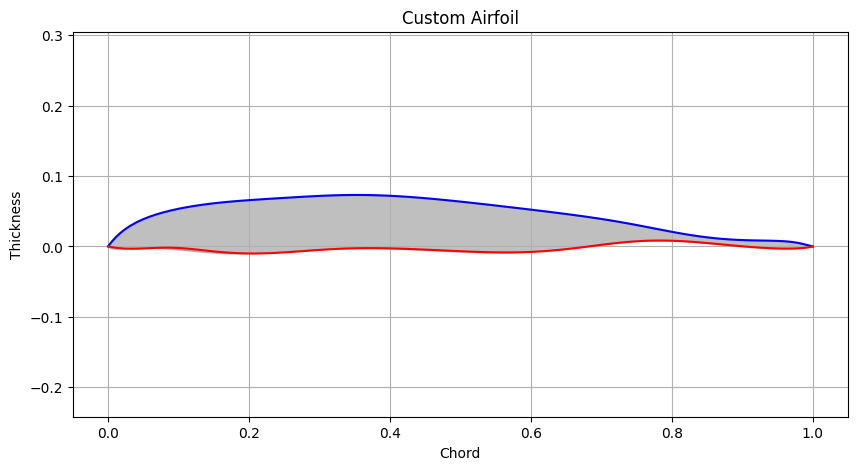

In [554]:

# generating random noise
random_noise = generate_noise(1)

ex_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(device)
ex_label = torch.tensor(np.array([0.5, 0.0, 0.0]), dtype=torch.float32).unsqueeze(0).to(device)
label_target = ex_label
print(f"label_target: {label_target}")

input_noise = random_noise.to(device)

print(f"random_noise: {label_target.shape}")
print(f"label_values: {input_noise.shape}")

# get the model output
gen_points = generator(input_noise, label_target)
print(f"Max: {max(gen_points[0])}")
print(f"Min: {min(gen_points[0])}")
# print(gen_points)
print(discriminator(gen_points))
print(discriminator(next(iter(train_dataloader))[0][0]))

# show_airfoil(point_array=gen_points.detach().cpu().numpy()[0])




# smooth the airfoil
def smooth_foil(array_y, window=5):

    # start by extending the data to make sure that the averaging function works
    array_y = np.pad(array_y, (window // 2), mode='edge')

    # compute the moving average using a kernel method
    mv_mat = np.ones(window) / window

    # resulting array 
    res = np.convolve(array_y, mv_mat, mode='valid')

    return res

# smoothing bezier version
def smooth_bezier(array_x, array_y):

    # define the nodes
    bezier_nodes = np.asfortranarray([array_x, array_y])
    
    # get the curve
    b_curve = bezier.Curve(bezier_nodes, degree=len(array_x) - 1)

    # generate a linear space
    b_line = np.linspace(0, 1, 100)
    res = b_curve.evaluate_multi(b_line)

    # print(b_line)

    # return the x and y
    return (res[0], res[1])


# define a function that sorts the points in either forward or reverse order and 
# gets the moving average of them over the airfoil
def sort_points_airfoil_edge(array_x, array_y, bottom=False):

    array_x = np.array(array_x)
    array_y = np.array(array_y)

    # sort the arrays using either reverse or forward and the x array
    # reverse when we are dealing with the bottom array
    sorted_indexes = np.argsort(array_x)

    # check if we should reverse
    if bottom:
        sorted_indexes = sorted_indexes[::-1]

    # sort the arrays
    array_x = array_x[sorted_indexes]
    array_y = array_y[sorted_indexes]

    return (array_x, array_y)

def smooth_airfoil(array_x, array_y):
    # now get the average of the points 
    # to make the airfoil more smooth
    if NORMAL_SMOOTH:
        array_y = smooth_foil(array_y, window=WINDOW_VAL)
    elif BEZIER_SMOOTH:
        (array_x, array_y) = smooth_bezier(array_x, array_y)
    
    return (array_x, array_y)

# show the plotted airfoil that we have created
# note that we have to start and end with (1.00000, 0.00000000)
# point_array: describes the airfoil that we are analyzing and plotting
# file_path: the path to the file that we are going to read and analyze
# normalize: should we fix and normalize the airfoil that we are working with
# format_for_xfoil: fix the airfoil that we return so that it is kosher for xfoil
def show_airfoil(point_array = None, file_path = None, normalize=True, format_for_xfoil=True):

    # check that the arguments are valid
    if point_array is None and file_path is None:
        raise ValueError("Improper arguments passed to the file")

    # if the file path is where we should be pulling from then get it
    if file_path is not None:
        point_array = get_points_from_dat_file(file_path)

    # if we did not read this from a file, then we are not running on tuples
    # and need to convert the points to tuples
    else:

        # define a new point array
        new_point_arr = []

        print(f"ADDING: {len(point_array) // 2}")

        # get all points
        for i in range(len(point_array) // 2):

            # add new tuples
            new_point_arr.append((point_array[2*i], point_array[2*i + 1]))

        # overwrite the old file
        point_array = new_point_arr


    # if VERBOSE:
    #     print(point_array)

    # split the points properly given that we have tuples
    xu, yu, xl, yl = [], [], [], []
    for i, point in enumerate(point_array):
        if i < len(point_array) / 2:
            xu.append(point[0])
            yu.append(point[1])
        else:
            xl.append(point[0])
            yl.append(point[1])

    for i in range(len(xu) > len(xl)):
        xu.append(xu[-1])
        yu.append(yu[-1])

    for i in range(len(xu) - len(xl)):
        xu.append(xu[-1])
        yu.append(yu[-1])

    xu.reverse()
    yu.reverse()
    
    
    # now fix the top and bottom
    if normalize:
        (xu, yu) = sort_points_airfoil_edge(xu, yu, bottom=False)
        (xl, yl) = sort_points_airfoil_edge(xl, yl, bottom=False)

    # add the top and bottom of the airfoil
    xl = np.append(xl, xu[-1])
    yl = np.append(yl, yu[-1])
    xl = np.append(xu[0], xl)
    yl = np.append(yu[0], yl)

    xu = np.append(xu, xl[-1])
    yu = np.append(yu, yl[-1])
    xu = np.append(xl[0], xu)
    yu = np.append(yl[0], yu)
    
    # smooth the airfoil out
    (xl, yl) = smooth_airfoil(xl, yl)
    (xu, yu) = smooth_airfoil(xu, yu)

    # re-split the points so that there is a top and a bottom
    point_array = []
    for _x, _y in zip(xu, yu):
        point_array.append((_x, _y))
    for _x, _y in zip(reversed(xl), reversed(yl)):
        point_array.append((_x, _y))

    # turn into numpy
    point_array = np.array(point_array)

    # remove duplicates
    new_arr = []
    seen_pairs = set()

    # iterate through the pairs
    for pair in point_array:

        if str(pair) not in seen_pairs:

            new_arr.append(pair)
        
        # add the pair to the seen set
        seen_pairs.add(str(pair))

    point_array = np.array(new_arr)

    # identify most left and most right points
    # print(f"MIN: {((index for index in range(len(point_array))), key=lambda x: point_array[x][1])}")
    # getting the min and the max x
    min_x_idx = None
    max_x_idx = None
    min_x = np.inf
    max_x = -np.inf

    for idx, pair in enumerate(point_array):
        if pair[0] < min_x:
            min_x_idx = idx
            min_x = pair[0]
        if pair[0] > max_x:
            max_x_idx = idx
            max_x = pair[0]

    # print(point_array)

    # split points into upper and lower using y-value comparisons
    leftmost_point = point_array[min_x_idx]
    rightmost_point = point_array[max_x_idx]

    # normalize the entire data array to between zero and 1 
    point_array = (point_array - min_x) / (max_x - min_x)


    # getting the x and y values for top and bottom
    xu = point_array[:max_x_idx, 0]
    yu = point_array[:max_x_idx, 1]
    xl = point_array[max_x_idx:, 0]
    yl = point_array[max_x_idx:, 1]

    # go ahead and normalize it to (0, 1) on either end
    (xl, yl) = smooth_airfoil(xl, yl)
    (xu, yu) = smooth_airfoil(xu, yu)

    # change to arrays
    xl = np.array(xl)
    yl = np.array(yl)
    # yl = np.array(list(reversed(yl)))
    xu = np.array(xu)
    yu = np.array(yu)

    # normalize the x distance
    xl = (xl - min(xl)) / (max(xl) - min(xl))
    xu = (xu - min(xu)) / (max(xu) - min(xu))

    # get the initial height and final height
    back_y = yu[-1]
    front_y = yu[0]

    # normalize by different ratio across airfoil
    len_arr = len(xl)
    for i in range(len_arr):
        yu[i] -= (back_y * (i / (len_arr - 1)) + front_y * (((len_arr - 1) - i) / (len_arr - 1))) 
        yl[i] -= (front_y * (i / (len_arr - 1)) + back_y * (((len_arr - 1) - i) / (len_arr - 1))) 
    
    
    delta_back = yl[0]
    delta_front =  yl[-1]
    
    for i in range(len_arr):
        yl[i] -= delta_front * (i / (len_arr - 1)) + delta_back * (((len_arr - 1) - i) / (len_arr - 1))





    # check if this is verbose
    if VERBOSE:
        print(f"point_array len: {len(point_array)}")
        print(f"max_x_idx: {max_x_idx}")
        print(f"min_x_idx: {min_x_idx}")
        print(f"delta_back: {delta_back}")
        print(f"delta_front: {delta_front}")
        print(f"back_y: {back_y}")
        print(f"front_y: {front_y}")
        print(f"xl: {len(xl)}")
        print(f"yl: {len(yl)}")
        print(f"xu: {len(xu)}")
        print(f"yu: {len(yu)}")
        # print(xl)    
        # print(yl)
        # print(xu)
        # print(yu)

    # plot airfoil
    plt.figure(figsize=(10, 5))
    plt.plot(xu, yu, 'b', xl, yl, 'r')  # upper in blue, lower in red
    plt.fill_between(xu, yu, list(reversed(yl)), color='gray', alpha=0.5)
    # plt.fill_between(xu, yu, yl, color='gray', alpha=0.5)
    plt.axis('equal')
    plt.title("NACA 4210 Airfoil" if point_array is None else "Custom Airfoil")
    plt.xlabel("Chord")
    plt.ylabel("Thickness")
    plt.grid(True)
    
    # save the figure
    plt.savefig("./output_plt.png", format='png', dpi=300)
    
    plt.show()


    # get the new point array
    point_array = []

    # if format_for_xfoil:
    #     point_array.append((1.00, 0.000))
    #     for _x, _y in zip(xl, yl):
    #         point_array.append((_x, _y))
    #     point_array.append((0.00, 0.000))
    #     for _x, _y in zip(xu, yu):
    #         point_array.append((_x, _y))
    #     point_array.append((1.00, 0.000))
    
    # else:
    for _x, _y in zip(xl, yl):
        point_array.append((_x, _y))
    for _x, _y in zip(xu, yu):
        point_array.append((_x, _y))

    # remove duplicates
    new_arr = []
    seen_pairs = set()

    # iterate through the pairs
    for pair in point_array:

        if str(pair) not in seen_pairs:

            new_arr.append(pair)
        
        # add the pair to the seen set
        seen_pairs.add(str(pair))

    # point_array.append((1.000, 0.000))
    # print(point_array)
    point_array = np.array(new_arr)

    point_array = np.append(point_array, [[1.00, 0.00]], axis = 0)

    # return the point array
    return point_array

gen_point_array = show_airfoil(point_array=gen_points.detach().cpu().numpy()[0])
# print(gen_point_array)

# _ = show_airfoil(point_array=next(iter(train_dataloader))[0][0].detach().cpu().numpy())

In [555]:

# state variables
MAC_PLATFORM = 1
LINUX_PLATFORM = 2
UNKNOWN_PLATFORM = 3
PLATFORM = UNKNOWN_PLATFORM


# getting the file that we are currently working in 
# CURR_FILE_DIR = os.path.dirname(os.path.realpath(__file__))
CURR_FILE_DIR = "."

# define the directory that we are working in for the example files
EXAMPLE_DIR = "Example Data"

# path to the example data
example_data_path = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, "b737a.dat")

# defining the data files that we are gonna use
output_file = "polar.txt"
example_data_output = os.path.join(CURR_FILE_DIR, output_file)
dump_file = "dump.txt"
example_data_dump = os.path.join(CURR_FILE_DIR, dump_file)





# define a function that we can pass command arrays to for xfoil
# this is for if we only have the command line version of XFoil running
def pass_to_xfoil(command_array):

    if VERBOSE:
        print(XFOIL_COMMAND)
        print(command_array)

    # start a subprocess
    # process = subprocess.run([XFOIL_COMMAND], input=command_array, text=True, capture_output=True)

    process = subprocess.Popen(
        [XFOIL_COMMAND],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    # get the output and errors
    output, errors = process.communicate(command_array)

    # return the std out
    # return process.stdout
    return output


# get everything before and including a line with a key word in a python string
def cut_string_at_keyword(text, keyword):
    
    # split the string into lines
    lines = text.split('\n')
    
    # go through each of the lines
    for i, line in enumerate(lines):
        
        # check if they keyword is in the line or not
        if keyword in line:
           
            # return the text up to and including the line with the keyword
            return '\n'.join(lines[:i+1])
        
    # if the keyword isn't found, return the original text
    return text  

# get the important information about the airfoil from the following function
def get_airfoil_information(xfoil_output):

    # get the thickness and the camber of the airfoil
    max_thickness_index = xfoil_output.index("Max thickness") + len("Max thickness")
    max_thickness_end_of_line = xfoil_output.find('\n', max_thickness_index)
    max_thickness_string = xfoil_output[max_thickness_index:max_thickness_end_of_line].strip()

    # get the value and the x pos
    max_thickness_x = float(max_thickness_string[max_thickness_string.index("at x = ") + len("at x = ") : ].strip())
    max_thickness_val = float(max_thickness_string[max_thickness_string.index("=") + 1 : max_thickness_string.index("at x = ") ].strip())

    # get the thickness and the camber of the airfoil
    max_camber_index = xfoil_output.index("Max camber") + len("Max camber")
    max_camber_end_of_line = xfoil_output.find('\n', max_camber_index)
    max_camber_string = xfoil_output[max_camber_index:max_camber_end_of_line].strip()

    # get the value and the x pos
    max_camber_x = float(max_camber_string[max_camber_string.index("at x = ") + len("at x = ") : ].strip())
    max_camber_val = float(max_camber_string[max_camber_string.index("=") + 1 : max_camber_string.index("at x = ") ].strip())


    # get everything up to "j/t"
    xfoil_output = cut_string_at_keyword(xfoil_output.lower(), "j/t")

    # parsing for the start of the bend info
    if VERBOSE:
        print(xfoil_output)
    bend_info_start = xfoil_output.index("area =")

    # cutting the string
    xfoil_bend_metrics = xfoil_output[bend_info_start : ]

    # go through and get all of the metrics from xfoil and return it to a dictionary
    # initialize an empty dictionary
    properties_dict = {}

    current_category = None

    # split the text by newlines and iterate through the lines
    lines = xfoil_bend_metrics.split('\n')
    for line in lines:
        
        # check the value and the key
        if '=' in line:

            # get the key and value
            key, value = line.split('=')
            key = key.strip()
            value = value.strip()

            # get the generated text
            if current_category is None or key == "j/t" or key == "j":
                properties_dict[key] = float(value) if 'e' in value or '.' in value else int(value)
            else:
                properties_dict[current_category][key] = float(value) if 'e' in value or '.' in value else int(value)

            if VERBOSE: 
                print(f"current_category: {current_category}\nKey: {key}\nValue: {value}\n")

        elif 'parameters' in line:
            category, material = line.split('(')
            category = category.strip().replace('-bending ', '-')
            material = material.strip('):')
            current_category = category + "_" + material
            properties_dict[current_category] = {}

    # adding the other information that we got at the start to the dictionary
    properties_dict["max_thickness_x"] = max_thickness_x
    properties_dict["max_thickness_val"] = max_thickness_val
    properties_dict["max_camber_x"] = max_camber_x
    properties_dict["max_camber_val"] = max_camber_val

    return properties_dict


# killing xquartz for speed on mac
def kill_xquartz():
    try:
        # find the pids
        ascript = '''
        tell application "System Events"
            set xquartzProcesses to every process whose name is "quartz-wm"
            repeat with proc in xquartzProcesses
                try
                    do shell script ("kill -9 " & (unix id of proc))
                end try
            end repeat
        end tell
        '''
        
        # kill each process found
        subprocess.run(["osascript", "-e", ascript])
        print(f"Killed XQuartz process")
            
    except subprocess.CalledProcessError:
        print("XQuartz is not running.")

# running the xfoil sim
def run_simulation(target_dir, target_file):

    target_polar = os.path.join(target_dir, output_file)
    target_dump = os.path.join(target_dir, dump_file)
     
    # run the simulation on the target directory
    airfoil_commands = f'''
    LOAD {target_file}
    OPER        
    OPER             
    PACC
    {target_polar}
    {target_dump}
    M {mach_number}
    VISC {reynolds_number}
    ASEQ {s_aot} {t_aot} {aot_increments}
    DUMP {dump_file}
    PACC

    QUIT
    '''

    # remove the files so that the program runs smoothly
    try:
        os.remove(target_polar)
    except:
        pass

    try:
        os.remove(target_dump)
    except:
        pass
    
    # run xfoil to get the airfoil metrics
    program_output = pass_to_xfoil(airfoil_commands)
    
    if VERBOSE:
        print(program_output)

    
    
    airfoil_commands = f'''
    LOAD {target_file.replace("_reformatted.dat", "_reformatted_full_points.dat")}   
    t_foil   
    BEND
    QUIT
    '''

    # getting the dictionary information
    program_output = pass_to_xfoil(airfoil_commands)

    if VERBOSE:
        print(airfoil_commands)
        print(program_output)

    # kill the XQuartz
    if PLATFORM == MAC_PLATFORM:
        kill_xquartz()

    # getting the airfoil information
    airfoil_info_dict = get_airfoil_information(program_output)

    with open(os.path.join(target_dir, "airfoil_info.pkl"), 'wb') as f:
        pickle.dump(airfoil_info_dict, f)

    if VERBOSE:
        print(airfoil_info_dict)

    # read the resulting csv for the information that we are looking for
    resulting_data = pd.read_csv(target_polar, sep='\s+', skiprows=10)
    resulting_data = resulting_data.drop(0)

    if VERBOSE:
        print(f"Resulting Data: {resulting_data}")



# save the foil that we create
# overwrite_basic allows us to overwrite the base file that we use to store all of the airfoils that we generate
# they are simply overwritten and we move on to the next
def save_foil_to_file(point_array, foil_title=None, base_dir="./generated_foils/", overwrite_basic=False):

    # try to create the directory
    os.makedirs("./generated_foils/0_gen_foil", exist_ok=True)

    # if we are overwriting the old file
    if overwrite_basic:

        # create new dir name
        dir_name = os.path.join(base_dir, f"0_gen_foil")
        write_path = os.path.join(dir_name, f"0_gen_foil.dat")
        
        # write the points to a file
        with open(write_path, 'w') as new_file:

            # write the points
            for x, y in point_array:
                new_file.write(f"{x:.6f}\t{y:.6f}\n")

        return

    else:
    
        # if we want to save this to a new file then do that
        file_idx = 0
        while True:
            
            # create new dir name
            dir_name = os.path.join(base_dir, f"{file_idx}_gen_foil")
            
            # check if this is a valid new dir
            if not os.path.exists(dir_name):
                os.makedirs(dir_name)
                break
            
            # inc if not valid (exists already)
            file_idx += 1

        # create a new file
        if foil_title is None:
            write_path = os.path.join(dir_name, f"{file_idx}_gen_foil.dat")
        else:
            write_path = os.path.join(dir_name, f"{foil_title}.dat")

        # write the points to a file
        with open(write_path, 'w') as new_file:

            # write the points
            for x, y in point_array:
                new_file.write(f"{x:.6f}\t{y:.6f}\n")

        # now copy and paste the image
        os.system(f"cp ./output_plt.png {dir_name}")

    print(f"Saved to {write_path}")

    return (dir_name, write_path)




# save_foil_to_file(gen_point_array, overwrite_basic=True)
(dir_p, file_p) = save_foil_to_file(gen_point_array, overwrite_basic=False)
run_simulation(dir_p, file_p)

Saved to ./generated_foils/23_gen_foil/23_gen_foil.dat
/Users/tristanbrigham/Desktop/Xfoil-for-Mac/bin/xfoil

    LOAD ./generated_foils/23_gen_foil/23_gen_foil.dat
    OPER        
    OPER             
    PACC
    ./generated_foils/23_gen_foil/polar.txt
    ./generated_foils/23_gen_foil/dump.txt
    M 0.3
    VISC 1000000.0
    ASEQ 2.0 6.0 1.0
    DUMP dump.txt
    PACC

    QUIT
    

  XFOIL Version 6.99
  Copyright (C) 2000   Mark Drela, Harold Youngren

  This software comes with ABSOLUTELY NO WARRANTY,
    subject to the GNU General Public License.

  Caveat computor

 File  xfoil.def  not found

   QUIT    Exit program

  .OPER    Direct operating point(s)
  .MDES    Complex mapping design routine
  .QDES    Surface speed design routine
  .GDES    Geometry design routine

   SAVE f  Write airfoil to labeled coordinate file
   PSAV f  Write airfoil to plain coordinate file
   ISAV f  Write airfoil to ISES coordinate file
   MSAV f  Write airfoil to MSES coordinate file
   REVE